# 289to305 (16-31 Oktober)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Oct16-31woPe.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_AGS_289to305']
X = df.loc[:, ~df.columns.isin(['std_inz_AGS_289to305'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  155


# First CatBoost Model with 155 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9995117126074909


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  2.2087787700662274


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

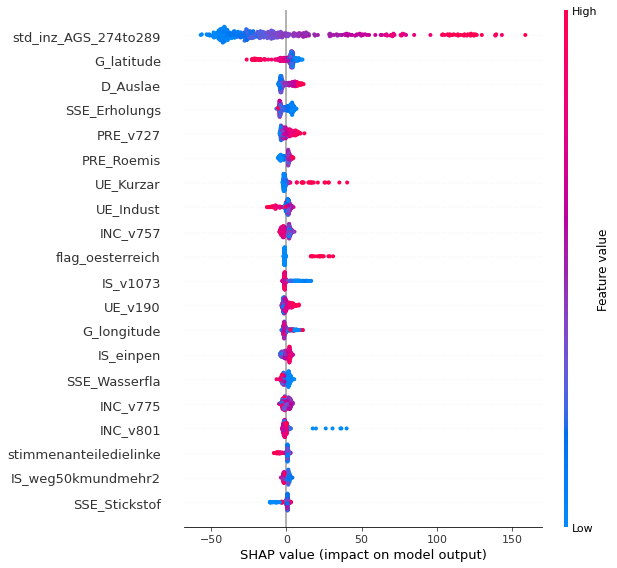

In [7]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [8]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [9]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.995213434517229


In [10]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  6.915545868560676


# Compare top 10 features of both Models

In [11]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_274to289', 'G_latitude', 'D_Auslae', 'SSE_Erholungs', 'PRE_v727', 'PRE_Roemis', 'UE_Kurzar', 'UE_Indust', 'INC_v757', 'flag_oesterreich'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_274to289', 'D_Auslae', 'G_latitude', 'PRE_Roemis', 'G_longitude', 'SSE_Erholungs', 'PRE_v727', 'IS_einpen', 'UE_Indust', 'SSE_Wasserfla']


In [12]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_274to289
G_latitude
D_Auslae
SSE_Erholungs
PRE_v727
PRE_Roemis
UE_Indust


ABS_SHAP(shap_values_cb_20,X[top20feature]) 

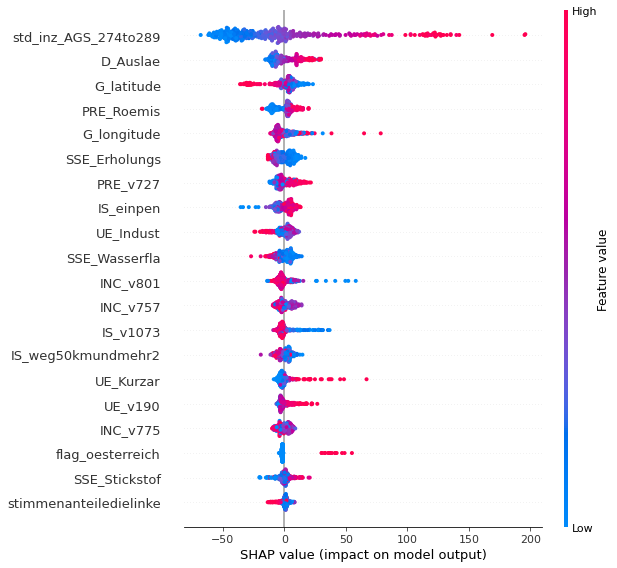

In [13]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [14]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [15]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9968607814407531
Mean R2 of linReg_modesl with top20 features:  0.6370383662070883
Mean RMSE of CatBoost_models on test sets with top20 features:  62.08701453742526
Mean R2 of CatBoost_models on test sets with top20 features: 0.6255350684333071


# descriptives of top20 features

In [16]:
X[top20feature].describe()

,std_inz_AGS_274to289,G_latitude,D_Auslae,SSE_Erholungs,PRE_v727,PRE_Roemis,UE_Kurzar,UE_Indust,INC_v757,flag_oesterreich,IS_v1073,UE_v190,G_longitude,IS_einpen,SSE_Wasserfla,INC_v775,INC_v801,stimmenanteiledielinke,IS_weg50kmundmehr2,SSE_Stickstof
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,52.453857,50.615307,10.034916,70.509460,11.654364,32.242802,0.752618,18.253864,8.945634,0.039900,88.700745,11.710723,9.866997,64.508949,123.133629,14.988532,2846.079834,8.822446,11.484292,68.331635
std,36.794933,1.740311,5.149191,56.734703,3.181232,24.361443,1.440882,8.723560,2.964478,0.195969,14.054544,3.008996,2.026269,10.002246,181.269791,4.460501,926.154114,4.537565,3.481254,27.160891
min,3.428815,47.500000,1.900000,14.000000,4.600000,1.700000,0.000000,0.000000,-14.300000,0.000000,20.000000,4.600000,6.083333,21.700001,2.600000,1.000000,28.000000,3.600000,4.900000,21.400000
25%,26.030115,49.283333,6.200000,39.700001,10.300000,7.900000,0.000000,12.700000,7.700000,0.000000,83.000000,10.600000,8.216666,58.799999,24.700001,12.600000,2706.000000,5.700000,9.000000,47.500000
50%,44.778191,50.549999,9.200000,52.799999,12.100000,29.100000,0.300000,17.200001,9.000000,0.000000,94.000000,12.400000,9.766666,66.000000,66.800003,15.000000,3052.000000,6.800000,10.800000,59.200001
75%,67.134506,51.849998,13.100000,76.699997,13.800000,52.299999,0.900000,22.700001,10.700000,0.000000,99.000000,13.600000,11.416667,71.300003,131.600006,17.700001,3329.000000,10.300000,13.300000,88.199997
max,267.674591,54.783333,35.000000,384.600006,20.400000,87.800003,19.600000,91.800003,24.700001,1.000000,100.000000,20.200001,14.983334,90.400002,1918.000000,35.599998,4855.000000,23.299999,24.200001,150.699997


In [17]:
pd.DataFrame(Y).describe()

,std_inz_AGS_289to305
count,401.000000
mean,196.861191
std,100.082146
min,21.628151
25%,124.023865
50%,180.949234
75%,250.004318
max,613.031067


In [ ]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')